In [199]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
import mplcyberpunk
import tqdm
from functions import nth_derivative, oscilador,sol_x

In [200]:
plt.style.use('cyberpunk')
#mplcyberpunk.make_lines_glow()

In [251]:
#5 el intervalo que queremos para x
ti=0.0
tf=10.0
#t=torch.linspace(ti,tf,60).view(-1,1)

x0_i=-0.5
x0_f=0.6

# v0_i=0.0
# v0_f=0.6

# delta_i=0.0
# delta_f=0.3

# omega_i=0.0
# omega_f=0.3

T=torch.cartesian_prod(torch.linspace(ti,tf,100),
                       torch.arange(x0_i,x0_f,0.1))
                     #   torch.arange(x0_i,x0_f,0.1))
                    #    torch.linspace(delta_i,delta_f,8),
                    #    torch.linspace(omega_i,omega_f,8))

T=T[torch.randperm(T.shape[0])]

In [252]:
#T.cuda()
T.cuda()

tensor([[ 8.2828e+00, -1.0000e-01],
        [ 3.4343e+00,  1.0000e-01],
        [ 3.7374e+00, -2.0000e-01],
        ...,
        [ 6.0606e+00, -2.0000e-01],
        [ 9.3939e+00, -5.0000e-01],
        [ 6.4646e+00,  2.7756e-17]], device='cuda:0')

In [253]:
T.shape

torch.Size([1100, 2])

In [254]:
nodos=16
ANN = nn.Sequential(nn.Linear(2, nodos), nn.Tanh(), nn.Linear(nodos,nodos),
                    #nn.Tanh(), nn.Linear(nodos,nodos),
                    #nn.Tanh(), nn.Linear(nodos,nodos),
                    #nn.Tanh(), nn.Linear(nodos,nodos),
                    # nn.Tanh(), nn.Linear(nodos,nodos),
                    nn.Tanh(),nn.Linear(nodos,1))
print(ANN)


Sequential(
  (0): Linear(in_features=2, out_features=16, bias=True)
  (1): Tanh()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): Tanh()
  (4): Linear(in_features=16, out_features=1, bias=True)
)


In [255]:
nth_derivative(ANN, T,2)

tensor([[0.0050],
        [0.0212],
        [0.0201],
        ...,
        [0.0122],
        [0.0037],
        [0.0102]], grad_fn=<ReshapeAliasBackward0>)

In [256]:
# def Param(T,net=ANN):
#     out = net(T)
#     b=1-torch.exp(ti-T)

#     #return torch.reshape(T[:,1],out.size()) + b*out
#     return 2.0 +() +b.reshape(out.shape)**2 * out

# def Param(T,net=ANN):
#     #T=[t,x0,v0]
#     b=1-torch.exp(ti-T[:,0])
#     a=(T[:,0]-ti)*T[:,2]
#     #return torch.reshape(T[:,1],out.size()) + b*out
#     return T[:,1].view(-1,1) + a.view(-1,1) + b.view(-1,1)**2*net(T)

def Param(T,net=ANN):
    out = net(T)
    a=(T[:,0]-ti)*1.0
    b=1-torch.exp(ti-T[:,0])
    #return torch.reshape(T[:,1],out.size()) + b*out
    return T[:,1].view(-1,1) +a.view(-1,1) +b.view(-1,1)**2 * out


In [257]:
Param(T)

tensor([[7.9091],
        [3.4380],
        [3.4313],
        ...,
        [5.6356],
        [8.6129],
        [6.2229]], grad_fn=<AddBackward0>)

In [245]:
# def cost(t):
#     #Dt = nth_derivative(Param, t,1)
#     DDt = nth_derivative(Param, t,2) #las derivadas de orden sup sólo respecto a t
#     #delta = T[:, 3]
#     #delta = delta.view(-1, 1)
#     #omega = T[:, 4]

#     osc = DDt - torch.sin(T[:,0]).view(-1,1)

#     return torch.linalg.norm(osc)
n=len(T)

def cost(t):
    Dt = nth_derivative(Param, t,1)
    DDt = nth_derivative(Param, t,2) #las derivadas de orden sup sólo respecto a t
    #delta = T[:, 3]
    #delta = delta.view(-1, 1)
    #omega = T[:, 4]

    osc = DDt + 1.5*Dt + 9.0*Param(t)
    #osc = DDt + t[:,3].view(-1,1)*Dt + t[:,4].view(-1,1)*Param(t)
    return torch.linalg.norm(osc)**2
    #return torch.sum(torch.pow(osc, 2))

In [258]:
cost(T)

tensor(2946723., grad_fn=<PowBackward0>)

In [269]:
#4 Error and optimizer
learning_rate=0.01
epocas=5000

#optimizer=torch.optim.SGD(ANN.parameters(),lr=learning_rate,momentum=0.9)
optimizer = torch.optim.Adam(ANN.parameters(), lr=learning_rate, weight_decay=0.1)
#optimizer = torch.optim.Adadelta(ANN.parameters(), lr=learning_rate)

Training: 100%|██████████████████████████████████████| 5000/5000 [00:48<00:00, 103.87it/s, loss=577]


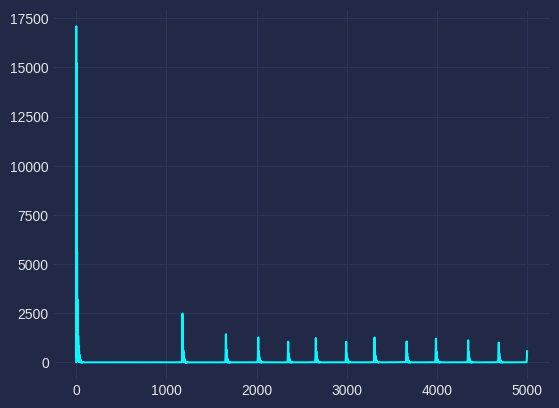

In [270]:
#loop de entrenamiendo 
pbar = tqdm.tqdm(range(epocas), desc="Training",  colour='cyan', ncols=100)

errores=[]
for i in pbar:
    l=cost(T) #coste
    #l=torch.nn.MSELoss(Param(T))
    l.backward() #gradiente
    optimizer.step() #se actualizan los parámetros
    optimizer.zero_grad() #vacíamos el gradiente
    #print('época=%.2f , loss=%.2f'%(i,l))
    errores.append(float(l))
    #tqdm.set_description('época: %d , loss: %.2f' % (i, l.item()))
    pbar.set_postfix({'loss': l.item()})
    #pbar.set_refresh(50)
    #tqdm.set_description("Training")
    #print('época=%.2f , loss=%.2f'%(i,l))

plt.plot(range(epocas),errores)

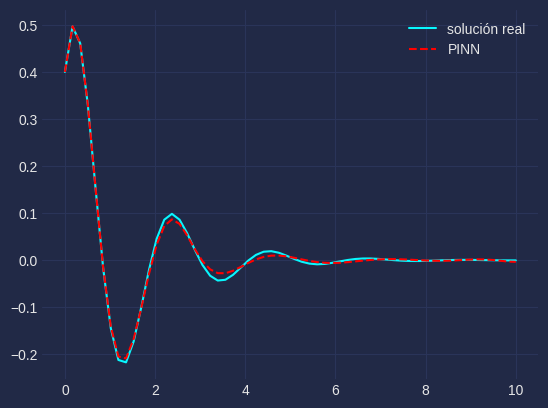

In [268]:
pos_ini=0.4
vel_ini=1.0
d=1.5
omega=3

t0 = torch.linspace(ti,tf,60)
x0 = pos_ini*torch.ones([t0.shape[0],1])
#v0 = vel_ini*torch.ones([t0.shape[0],1])
# delta0 = d*torch.ones([t0.shape[0],1])
# omega0 = omega*torch.ones([t0.shape[0],1])

X=torch.cat((t0.view(-1,1),x0),1)
X.cuda()
#plt.plot(t0, -torch.sin(t0)+2*t0+pos_ini, label='solución real')
plt.plot(t0.detach(), sol_x([pos_ini,vel_ini], t0, d, omega), label='solución real')
plt.plot(X[:,0],Param(X).detach().numpy(),'--r', label='PINN')
#plt.plot(t0.view(-1,1),Param(t0.view(-1,1)).detach().numpy(),'--r', label='PINN')
plt.legend()

In [263]:
%timeit Param(X).detach().numpy()

253 µs ± 26.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [264]:
%timeit sol_x([pos_ini,vel_ini], t0, d, omega) #odeint

1.15 ms ± 32.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [165]:
X

tensor([[ 0.0000, -0.1000],
        [ 0.1695, -0.1000],
        [ 0.3390, -0.1000],
        [ 0.5085, -0.1000],
        [ 0.6780, -0.1000],
        [ 0.8475, -0.1000],
        [ 1.0169, -0.1000],
        [ 1.1864, -0.1000],
        [ 1.3559, -0.1000],
        [ 1.5254, -0.1000],
        [ 1.6949, -0.1000],
        [ 1.8644, -0.1000],
        [ 2.0339, -0.1000],
        [ 2.2034, -0.1000],
        [ 2.3729, -0.1000],
        [ 2.5424, -0.1000],
        [ 2.7119, -0.1000],
        [ 2.8814, -0.1000],
        [ 3.0508, -0.1000],
        [ 3.2203, -0.1000],
        [ 3.3898, -0.1000],
        [ 3.5593, -0.1000],
        [ 3.7288, -0.1000],
        [ 3.8983, -0.1000],
        [ 4.0678, -0.1000],
        [ 4.2373, -0.1000],
        [ 4.4068, -0.1000],
        [ 4.5763, -0.1000],
        [ 4.7458, -0.1000],
        [ 4.9153, -0.1000],
        [ 5.0847, -0.1000],
        [ 5.2542, -0.1000],
        [ 5.4237, -0.1000],
        [ 5.5932, -0.1000],
        [ 5.7627, -0.1000],
        [ 5.9322, -0

In [166]:
torch.save(ANN.state_dict(),'oscilador_dict')

In [167]:
ANN.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0503, -0.7429],
                      [ 0.9826,  0.1893],
                      [ 0.1018, -0.4426],
                      [ 0.0964,  0.8514],
                      [ 0.0247, -0.0747],
                      [-0.1479, -0.0502],
                      [ 0.0399, -0.6940],
                      [-0.1785, -0.2274],
                      [-0.1794, -0.1360],
                      [-0.1723,  0.0442],
                      [ 0.2074, -0.2322],
                      [-0.0214, -0.0337],
                      [ 0.0682, -0.2028],
                      [-0.2063,  0.1072],
                      [ 0.0763, -0.0302],
                      [-0.0728, -0.1455],
                      [ 0.0732,  0.0549],
                      [ 1.4922, -1.2189],
                      [ 0.1417,  0.0246],
                      [ 0.8518,  0.3032],
                      [ 1.1196,  1.0317],
                      [ 0.0808,  0.3923],
                      [-0.0674, -0.2163],
        

In [168]:
torch.nn.MSELoss(ANN)

/home/kingsman/.local/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


MSELoss()

In [169]:
torch.sum(torch.tensor([[1,2,3]]),2)

IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

In [ ]:
torch.sum(Param(T))

tensor(-1.2626, grad_fn=<SumBackward0>)